In [125]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler

В связи с тем, что датасет был изначально выбран для задачи классификации, попробовав применить разные модели для задачи регрессии, у меня не получить получить коэффициент детерминации выше 0.85. По этой причине я взяла другой датасет для задачи регрессии.

Описание: Этот набор данных используется для оценки эффективности энергопотребления зданий. Цель состоит в предсказании отопительных и охлаждающих нагрузок здания на основе 8 входных переменных, таких как площадь, ориентация и др.

In [167]:
data = pd.read_csv("/content/energy_efficiency_data.csv")
data.head(3)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33


Посмотрим размер датасета, его фичи и стастистическую информацию

In [168]:
print(data.shape)
print(data.columns)
print(data.describe())

(768, 10)
Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')
       Relative_Compactness  Surface_Area   Wall_Area   Roof_Area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167    671.708333  318.500000  176.604167   
std                0.105777     88.086116   43.626481   45.165950   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.682500    606.375000  294.000000  140.875000   
50%                0.750000    673.750000  318.500000  183.750000   
75%                0.830000    741.125000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       Overall_Height  Orientation  Glazing_Area  Glazing_Area_Distribution  \
count       768.00000   768.000000    768.000000                  768

Посмотрим количество ненулевых значений

In [169]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None


Построим тепловую карту. На нем увидим, что наибольшую корреляцию с таргетом имеет столбец "Foof_Area". Это понадобится нам для последнего пункта

<Axes: >

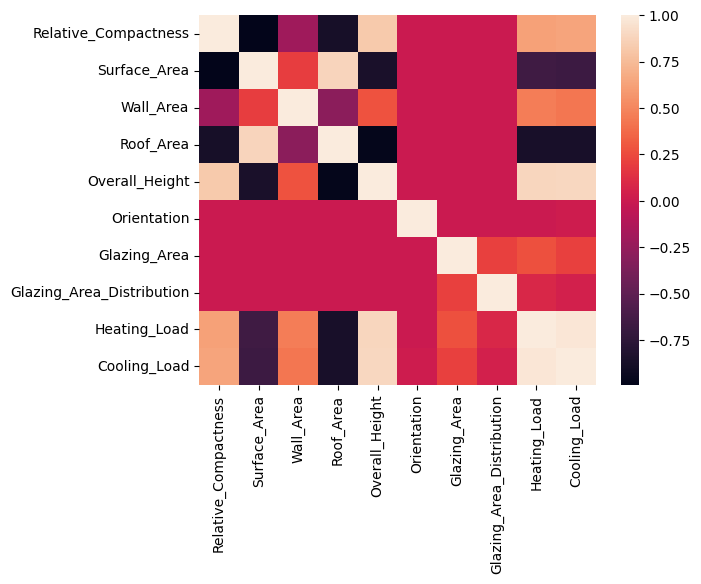

In [171]:
sns.heatmap(data.corr())

Выберем в качестве таргета охладительную нагрузку здания . Исключим ее из датасета.

In [172]:
y = data.pop('Cooling_Load')

In [173]:
df = data

Разделим на тест и трейн - 70/30

In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=17, shuffle=True
)

Масштабируем

In [175]:
scaler = MinMaxScaler()
df_scaled_train = scaler.fit_transform(X_train)
df_scaled_test = scaler.fit_transform(X_test)

Функция для расчета нужных метрик

In [176]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

Обучим модель **линейной регрессии** на трейне. Сделаем предсказание на тесте и посмотрим метрики.

In [177]:
modelLR = LinearRegression()
modelLR.fit(df_scaled_train, y_train)
y_pr_LR = modelLR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelLR, df_scaled_train, y_train, df_scaled_test, y_test, y_pr_LR)

RMSE:  1.9296
  R2: 0.9578
 Adjusted R2: 0.9561
 Cross Validated R2: 0.9566


**Поминомиальная регрессия**

In [178]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_train = poly.fit_transform(df_scaled_train)
poly_features_test = poly.fit_transform(df_scaled_test)

modelPR = LinearRegression()
modelPR.fit(poly_features_train, y_train)
y_pr_PR = modelPR.predict(poly_features_test)
_ = Reg_Models_Evaluation_Metrics(modelPR, poly_features_train, y_train, poly_features_test, y_test, y_pr_PR)

RMSE:  1.353
  R2: 0.9792
 Adjusted R2: 0.566
 Cross Validated R2: 0.9746


**Деревья принятия решений**

In [179]:
modelDT = DecisionTreeRegressor()
modelDT.fit(df_scaled_train, y_train)
y_dt_pred = modelDT.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelDT, df_scaled_train, y_train, df_scaled_test, y_test, y_dt_pred)

RMSE:  1.7385
  R2: 0.9657
 Adjusted R2: 0.9643
 Cross Validated R2: 0.9646


**Случайный лес**

In [180]:
modelRF = RandomForestRegressor(n_estimators=100)
modelRF.fit(df_scaled_train, y_train)
y_rf_pred = modelRF.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelRF, df_scaled_train, y_train, df_scaled_test, y_test, y_rf_pred)

RMSE:  1.4244
  R2: 0.977
 Adjusted R2: 0.9761
 Cross Validated R2: 0.977


**Метод опорных векторов**

In [181]:
from sklearn.svm import SVR

modelSVR = SVR(kernel='poly')
modelSVR.fit(df_scaled_train, y_train)
y_svr_pred = modelSVR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelSVR, df_scaled_train, y_train, df_scaled_test, y_test, y_svr_pred)

RMSE:  1.9894
  R2: 0.9551
 Adjusted R2: 0.9533
 Cross Validated R2: 0.9546


**ElasticNet**

In [182]:
from sklearn.linear_model import ElasticNet

modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)
modelEN.fit(df_scaled_train, y_train)
y_en_pred = modelEN.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelEN, df_scaled_train, y_train, df_scaled_test, y_test, y_en_pred)

RMSE:  2.6886
  R2: 0.918
 Adjusted R2: 0.9147
 Cross Validated R2: 0.9154


Градиентный бустинг


In [183]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

modelGBR = GradientBoostingRegressor(random_state=0)
modelGBR.fit(df_scaled_train, y_train)
y_gbr_pred = modelGBR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelGBR, df_scaled_train, y_train, df_scaled_test, y_test, y_gbr_pred)

RMSE:  1.4463
  R2: 0.9763
 Adjusted R2: 0.9753
 Cross Validated R2: 0.9784


Наилушее качество у моделей: полиноминальная регрессия и градиентный бустинг.

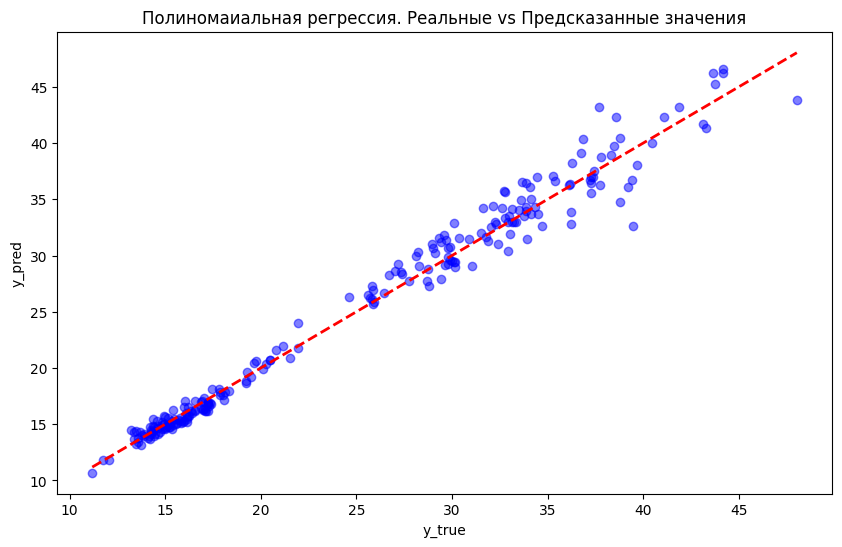

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pr_PR, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Диагональная линия
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Полиномаиальная регрессия. Реальные vs Предсказанные значения')
plt.show()


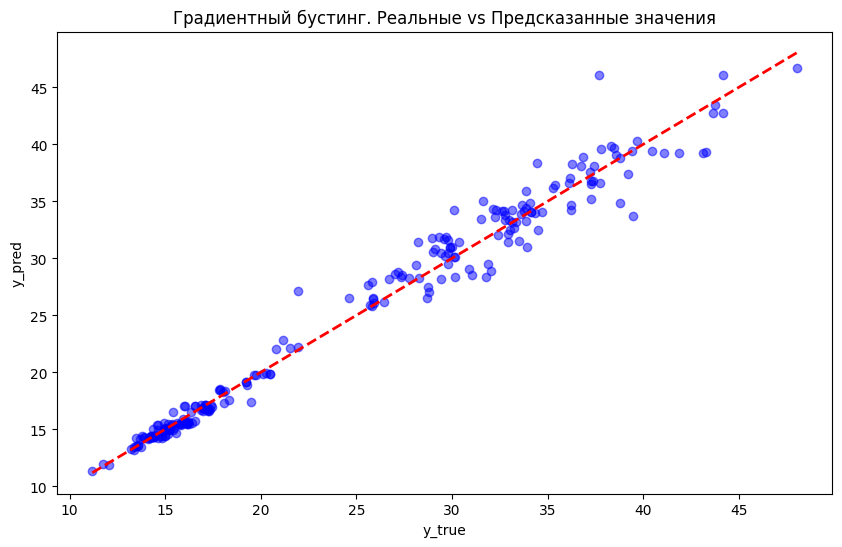

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_gbr_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Диагональная линия
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Градиентный бустинг. Реальные vs Предсказанные значения')
plt.show()


Визуализируем зависимость между одним параметром и целевой переменной

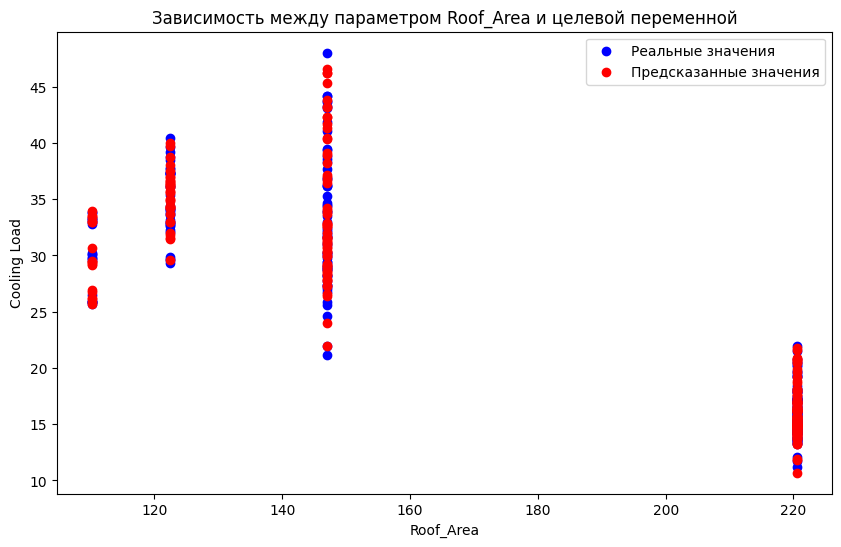

In [187]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test['Roof_Area'], y_test, color='blue', label='Реальные значения')
plt.scatter(X_test['Roof_Area'], y_pr_PR, color='red', label='Предсказанные значения')
plt.xlabel('Roof_Area')
plt.ylabel('Cooling Load')
plt.title('Полиномиальная регрессия. Зависимость между параметром Roof_Area и целевой переменной')
plt.legend()
plt.show()


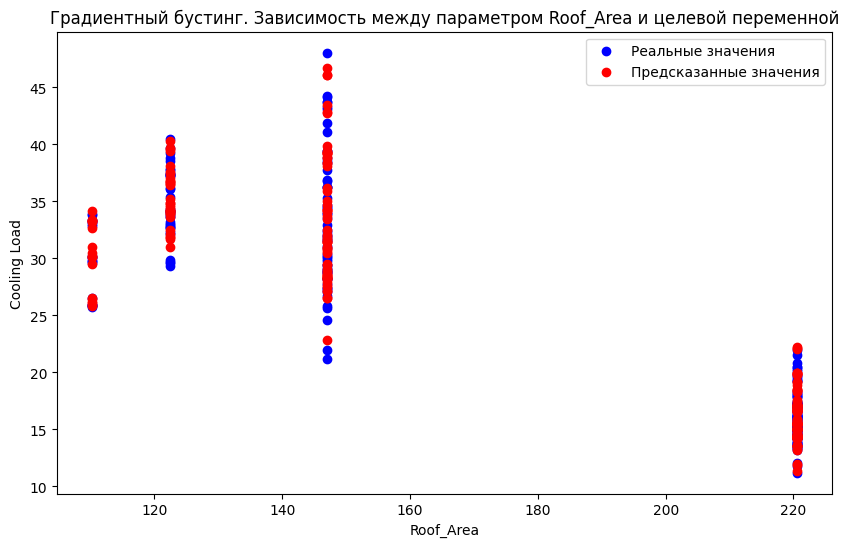

In [188]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test['Roof_Area'], y_test, color='blue', label='Реальные значения')
plt.scatter(X_test['Roof_Area'], y_gbr_pred, color='red', label='Предсказанные значения')
plt.xlabel('Roof_Area')
plt.ylabel('Cooling Load')
plt.title('Градиентный бустинг. Зависимость между параметром Roof_Area и целевой переменной')
plt.legend()
plt.show()
